In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('admissions_data.csv')
df.head()

Serial No.  GRE Score  TOEFL Score  ...  CGPA  Research  Chance of Admit 
0           1        337          118  ...  9.65         1              0.92
1           2        324          107  ...  8.87         1              0.76
2           3        316          104  ...  8.00         1              0.72
3           4        322          110  ...  8.67         1              0.80
4           5        314          103  ...  8.21         0              0.65

[5 rows x 9 columns]

In [3]:
df = df.drop(columns = ["Serial No."])
df.describe()

GRE Score  TOEFL Score  ...    Research  Chance of Admit 
count  500.000000   500.000000  ...  500.000000         500.00000
mean   316.472000   107.192000  ...    0.560000           0.72174
std     11.295148     6.081868  ...    0.496884           0.14114
min    290.000000    92.000000  ...    0.000000           0.34000
25%    308.000000   103.000000  ...    0.000000           0.63000
50%    317.000000   107.000000  ...    1.000000           0.72000
75%    325.000000   112.000000  ...    1.000000           0.82000
max    340.000000   120.000000  ...    1.000000           0.97000

[8 rows x 8 columns]

In [4]:
labels = df.iloc[:, -1]
labels

0      0.92
1      0.76
2      0.72
3      0.80
4      0.65
       ... 
495    0.87
496    0.96
497    0.93
498    0.73
499    0.84
Name: Chance of Admit , Length: 500, dtype: float64

In [5]:
feature = df.iloc[:, : -1]
feature

GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  Research
0          337          118                  4  4.5   4.5  9.65         1
1          324          107                  4  4.0   4.5  8.87         1
2          316          104                  3  3.0   3.5  8.00         1
3          322          110                  3  3.5   2.5  8.67         1
4          314          103                  2  2.0   3.0  8.21         0
..         ...          ...                ...  ...   ...   ...       ...
495        332          108                  5  4.5   4.0  9.02         1
496        337          117                  5  5.0   5.0  9.87         1
497        330          120                  5  4.5   5.0  9.56         1
498        312          103                  4  4.0   5.0  8.43         0
499        327          113                  4  4.5   4.5  9.04         0

[500 rows x 7 columns]

In [6]:
# there are no categorical variables in this dataset, so do not have to perform one-hot encoding. 

In [7]:
features_train, features_test, labels_train, labels_test = train_test_split(
    feature, 
    labels, 
    test_size = 0.33,
    random_state = 42
)

In [8]:
numerical_features = feature.select_dtypes(
    include = ['float64', 'int64']
)
numerical_columns = numerical_features.columns

ct = ColumnTransformer(
    [(
        "only numeric", 
        StandardScaler(), 
        numerical_columns 
    )], 
    remainder = "passthrough"
)

features_train_scaled = ct.fit_transform(features_train)
features_test_scaled = ct.transform(features_test)

In [9]:
features_train_norm = pd.DataFrame(
  features_train_scaled, 
  columns = features_train.columns
)
features_train_norm

GRE Score  TOEFL Score  University Rating  ...      LOR       CGPA  Research
0    -0.525175    -0.706986          -0.082885  ...  0.538819 -0.835766 -1.144703
1     0.477036     0.276434           1.652517  ... -0.001613  0.363045 -1.144703
2    -0.798505    -1.034792          -0.950586  ...  0.538819 -1.156574 -1.144703
3     0.203706    -0.706986          -0.082885  ...  0.538819  0.295507  0.873589
4     1.297027     1.423757           1.652517  ...  1.619684  1.342356  0.873589
..         ...          ...                ...  ...       ...       ...       ...
330   1.114806     0.604240           0.784816  ...  1.079251  1.004663  0.873589
331  -0.980725    -0.379179          -0.950586  ... -0.542045 -0.616265  0.873589
332  -1.345165    -1.362599          -1.818287  ... -1.622910 -2.254077 -1.144703
333  -0.707395    -0.379179          -0.950586  ...  0.538819 -1.528037 -1.144703
334  -0.251845    -0.215276          -0.950586  ... -0.001613 -0.565611 -1.144703

[335 rows x 7 columns]

In [10]:
def design_model(X, learning_rate):
    layers = tf.keras.layers
    Dense = tf.keras.layers.Dense

    model = tf.keras.models.Sequential()
    input = layers.InputLayer(input_shape = (X.shape[1], ))
    model.add(input)
    
    model.add(
        Dense(
            7, 
            activation = "relu" 
        )
    )

    model.add(Dense(1))
    #print(model.summary())

    opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(
        loss = "mse",  
        metrics = ["mae"], 
        optimizer = opt
    )

    return model

def fit_model(features_train, labels_train, learning_rate, num_epochs):
    model = design_model(features_train, learning_rate)
    stop = tf.keras.callbacks.EarlyStopping(
        monitor = "val_loss", 
        mode = "min",
        verbose = 1, 
        patience = 40 
    )
    history = model.fit(
        features_train,
        labels_train,
        epochs = num_epochs,
        batch_size = 16,
        verbose = 0,
        validation_split = 0.2,        #  20% of the data would be allocated for validation
        callbacks = [stop]
    )
    return history

In [11]:
learning_rate = 0.01
num_epochs = 1000
history = fit_model(features_train_scaled, labels_train, learning_rate, num_epochs)
for property, value in vars(history).items():
    #print(property, ":", value)
    pass

Epoch 00091: early stopping


In [12]:
val_mse, val_mae = history.model.evaluate(
  features_test, 
  labels_test, 
  verbose = 0
)

print("MAE: ", val_mae)

MAE:  1.854364037513733


In [13]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


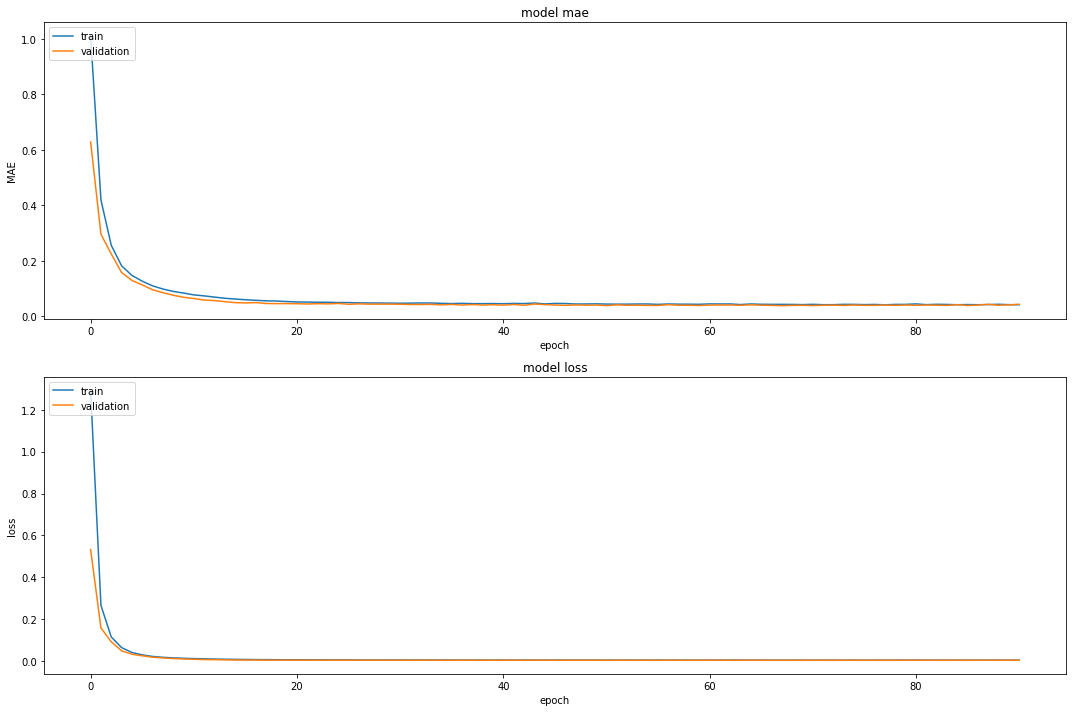

In [14]:
fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['mae'])
ax1.plot(history.history['val_mae'])
ax1.set_title('model mae')
ax1.set_ylabel('MAE')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')
 
  # Plot loss and val_loss over each epoch
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper left')
 
# used to keep plots from overlapping each other  
fig.tight_layout()